In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from itertools import repeat
from scipy.spatial import distance
import pickle
import torch
from torch import linalg
import numpy as np
from scipy.linalg import cho_solve

In [3]:
def load_object(repo: str, file: str):
    # Path constant to save the object
    PATH = f'{repo}/{file}.pkl'

    with open(PATH, 'rb') as f:
        return pickle.load(f)

features = load_object('../../data/train', 'donut')
features = torch.from_numpy(features)

In [7]:
C = 300
D = 2

means = torch.zeros(C, D, dtype=torch.float64).normal_(0, 0.5)

In [62]:
L = torch.normal(1, 1, size=(C, 1, 1)) * torch.eye(D, D).view(1, D, D)
sigmas = (L).type(torch.float64).contiguous()

In [63]:
def _sqrd_params(Si, Sj, mui, muj) -> torch.Tensor:
        # Compute the squared Gaussian params
        sigma = torch.inverse(Si + Sj)
        mu = sigma @ (Si @ mui + Sj @ muj)

        return (sigma, mu)

cluster_ids = torch.Tensor(range(C))
cartesian_ids = torch.cartesian_prod(cluster_ids, cluster_ids)
cartesian_ids = cartesian_ids.data.cpu().numpy().astype(int)

recomputed_params = {
    'means': [],
    'sigmas': []
}

for (i, j) in cartesian_ids:
    Si = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    Sj = torch.tril(sigmas[j]) @ torch.tril(sigmas[j]).t()
    
    sigma, mean = _sqrd_params(Si, Sj, means[i], means[j])
    
    recomputed_params['sigmas'].append(sigma.data.cpu().numpy())
    recomputed_params['means'].append(mean.data.cpu().numpy())

In [64]:
sqrd_gen_variance = []
gen_variance = []

for i in range(C):
    S_sqrd = recomputed_params['sigmas'][i]
    sqrd_gen_variance.append(np.linalg.det(S_sqrd))
    
    S = torch.tril(sigmas[i]) @ torch.tril(sigmas[i]).t()
    S = S.data.cpu().numpy()
    
    gen_variance.append(np.linalg.det(S))

sqrd_gen_variance = np.array(sqrd_gen_variance)
gen_variance = np.array(gen_variance)

[<matplotlib.patches.Patch object at 0x7faaec9e8ca0>, <matplotlib.patches.Patch object at 0x7faaec9e8ca0>]


<Figure size 640x480 with 0 Axes>

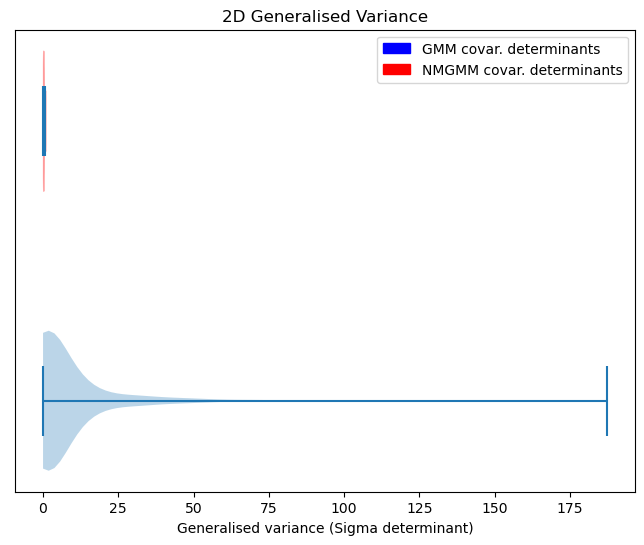

<Figure size 640x480 with 0 Axes>

In [65]:
fig = plt.figure()

# Create an axes instance
fig, ax = plt.subplots(figsize=(8,6))
ax.set_yticks([], [])

ax.set_title('2D Generalised Variance')
ax.set_xlabel('Generalised variance (Sigma determinant)')


red_patch = mpatches.Patch(color='red')
# 'fake' invisible object

pos   = [1, 2]
label = ['GMM covar. determinants','NMGMM covar. determinants']

fake_handles = repeat(red_patch, len(pos))
print(list(fake_handles))

# Create the boxplot
violin_parts = ax.violinplot([gen_variance, sqrd_gen_variance], vert=False)
violin_parts['bodies'][1].set_facecolor('red')
violin_parts['bodies'][1].set_edgecolor('red')


ax.legend([mpatches.Patch(color='blue'), mpatches.Patch(color='red')], label)

plt.show()
plt.draw()
fig.savefig('generalised_variance.png')